# Federated Learning Simple Implementation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

## MLP Model

In [150]:
class MLP(nn.Module):
    def __init__(self, layers_shape):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers_shape[i], layers_shape[i+1]) for i in range(len(layers_shape) - 1)]) # Define layers list
        self.relu = nn.ReLU() # activation function
        self.soft = nn.Softmax() # output function

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the input image
        for layer in self.linears[:-1]:
            x = self.relu(layer(x))
        # x = self.soft(self.linears[-1](x))
        x = self.linears[-1](x)
        return x

## Relevant Parameters

In [151]:
epoch = 5
comm_cycles = 25
num_clients = 10
sample_size = int(.3 * num_clients) # Use 30% of available clients
net_parameters = [ 28 * 28, # input
                512, 256, 128, 64,
                10 ] #output

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [152]:
# define transformation to apply to each image in the dataset
transform = transforms.Compose([
    transforms.ToTensor(), # convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the image with mean=0.5 and std=0.5
])

# load the MNIST training and testing datasets
train_dataset = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

# split the training data
train_split = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# create data loaders to load the datasets in batches during training and testing
train_loader = [torch.utils.data.DataLoader(split, batch_size=64, shuffle=True) for split in train_split]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## Helper Functions for Federated Training
- `client_update` function train the client model on private client data. This is the local training round that takes place at num_selected clients.
- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [153]:
def client_update(  client_model : torch.nn.Module,
                    optimizer,
                    criterion,
                    data_loader : torch.utils.data.DataLoader,
                    device,
                    epoch = 5):
    """
    Train the client model on client data
    """
    client_model.train()
    for e in range(epoch):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() # reset the gradients to zero
            output = client_model(images) # forward pass
            loss = criterion(output, labels) # compute the loss
            loss.backward() # compute the gradients
            optimizer.step() # update the parameters

    return loss.item() * images.size(0)

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Test Function
Similar to previous implementation, 

In [154]:

def test(global_model, criterion, test_loader, device):
    """This function test the global model on test data and returns test loss and test accuracy """
    global_model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = global_model(images) # forward pass
            loss = criterion(output, labels)
            test_loss += loss.item() * images.size(0)# sum up batch loss
            _, pred = torch.max(output, 1) # get the predicted labels
            test_acc += torch.sum(pred == labels.data).item() # compute the testing accuracy

    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)

    return test_loss, test_acc

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [155]:
global_model = MLP(net_parameters)
client_models = [MLP(net_parameters) for _ in range(num_clients)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model.to(device)
for model in client_models:
    model.to(device)
    model.load_state_dict(global_model.state_dict())

criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
optimizers =[optim.Adam(model.parameters(), lr=0.001) for model in client_models]


In [156]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for cycle in tqdm(range(comm_cycles)):
    # Select random clients
    client_idx = np.random.permutation(num_clients)[:sample_size]
    train_loss = 0
    for i in range(sample_size):
        train_loss += client_update(client_models[client_idx[i]],
                                    optimizers[client_idx[i]],
                                    criterion, train_loader[client_idx[i]],
                                    device, epoch)
    train_losses.append(train_loss)

    # Aggregate
    server_aggregate(global_model, client_models)

    test_loss, test_acc = test(global_model, criterion, test_loader, device)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{cycle}-th CYCLE: average train loss {(train_loss / sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  4%|▍         | 1/25 [00:16<06:36, 16.50s/it]

0-th CYCLE: average train loss 17.3 | test loss 2.15 | test acc: 0.437


  8%|▊         | 2/25 [00:32<06:14, 16.30s/it]

1-th CYCLE: average train loss 10.7 | test loss 1.65 | test acc: 0.893


 12%|█▏        | 3/25 [00:48<05:57, 16.27s/it]

2-th CYCLE: average train loss 5.22 | test loss 0.938 | test acc: 0.938


 16%|█▌        | 4/25 [01:05<05:41, 16.25s/it]

3-th CYCLE: average train loss 6.73 | test loss 0.451 | test acc: 0.950


 20%|██        | 5/25 [01:21<05:24, 16.21s/it]

4-th CYCLE: average train loss 3.71 | test loss 0.247 | test acc: 0.958


 24%|██▍       | 6/25 [01:37<05:07, 16.17s/it]

5-th CYCLE: average train loss 5.57 | test loss 0.167 | test acc: 0.963


 28%|██▊       | 7/25 [01:53<04:51, 16.20s/it]

6-th CYCLE: average train loss 2.53 | test loss 0.132 | test acc: 0.966


 32%|███▏      | 8/25 [02:09<04:35, 16.21s/it]

7-th CYCLE: average train loss 5.18 | test loss 0.115 | test acc: 0.968


 36%|███▌      | 9/25 [02:26<04:19, 16.21s/it]

8-th CYCLE: average train loss 3.58 | test loss 0.111 | test acc: 0.968


 40%|████      | 10/25 [02:42<04:02, 16.18s/it]

9-th CYCLE: average train loss 3.88 | test loss 0.1 | test acc: 0.971


 44%|████▍     | 11/25 [02:58<03:46, 16.19s/it]

10-th CYCLE: average train loss 3.1 | test loss 0.0921 | test acc: 0.972


 48%|████▊     | 12/25 [03:14<03:30, 16.18s/it]

11-th CYCLE: average train loss 6.87 | test loss 0.0932 | test acc: 0.973


 52%|█████▏    | 13/25 [03:30<03:14, 16.17s/it]

12-th CYCLE: average train loss 2.78 | test loss 0.0892 | test acc: 0.973


 56%|█████▌    | 14/25 [03:46<02:57, 16.15s/it]

13-th CYCLE: average train loss 2 | test loss 0.087 | test acc: 0.974


 60%|██████    | 15/25 [04:02<02:41, 16.15s/it]

14-th CYCLE: average train loss 4.92 | test loss 0.0835 | test acc: 0.975


 64%|██████▍   | 16/25 [04:19<02:25, 16.17s/it]

15-th CYCLE: average train loss 1.96 | test loss 0.0798 | test acc: 0.976


 68%|██████▊   | 17/25 [04:35<02:09, 16.15s/it]

16-th CYCLE: average train loss 3.52 | test loss 0.0782 | test acc: 0.976


 72%|███████▏  | 18/25 [04:51<01:52, 16.11s/it]

17-th CYCLE: average train loss 2.5 | test loss 0.0823 | test acc: 0.976


 76%|███████▌  | 19/25 [05:07<01:36, 16.13s/it]

18-th CYCLE: average train loss 3.18 | test loss 0.0774 | test acc: 0.977


 80%|████████  | 20/25 [05:23<01:20, 16.19s/it]

19-th CYCLE: average train loss 0.688 | test loss 0.0763 | test acc: 0.978


 84%|████████▍ | 21/25 [05:39<01:04, 16.01s/it]

20-th CYCLE: average train loss 0.798 | test loss 0.0771 | test acc: 0.978


 88%|████████▊ | 22/25 [05:54<00:47, 15.87s/it]

21-th CYCLE: average train loss 3.91 | test loss 0.077 | test acc: 0.978


 92%|█████████▏| 23/25 [06:10<00:31, 15.77s/it]

22-th CYCLE: average train loss 2.29 | test loss 0.0766 | test acc: 0.978


 96%|█████████▌| 24/25 [06:25<00:15, 15.65s/it]

23-th CYCLE: average train loss 4.22 | test loss 0.0766 | test acc: 0.979


100%|██████████| 25/25 [06:41<00:00, 16.05s/it]

24-th CYCLE: average train loss 1.03 | test loss 0.0761 | test acc: 0.978


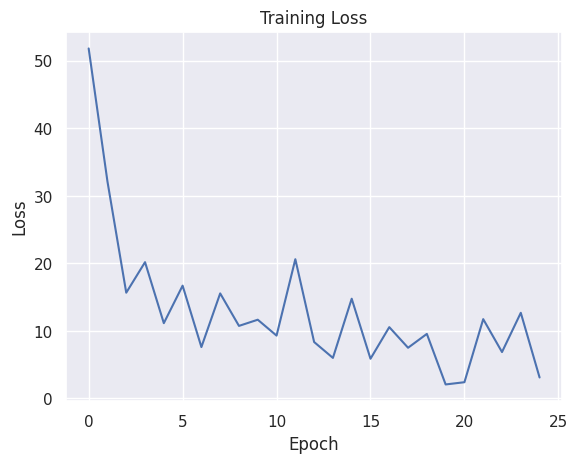

In [157]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

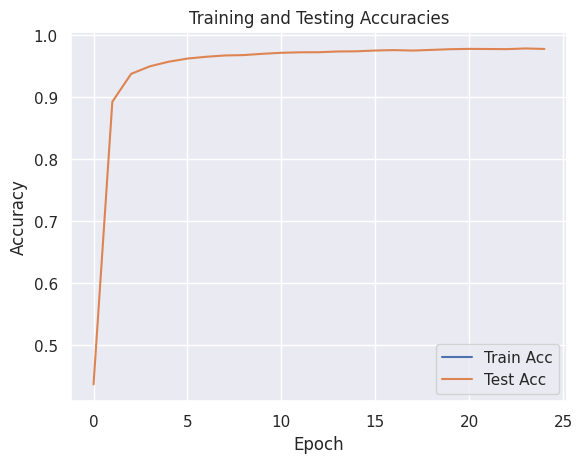

In [158]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
